In [32]:
import torch
from transformers import CLIPProcessor, CLIPModel

In [33]:
import torchvision.transforms.functional as TF,torch.nn.functional as F
from miniai.datasets import *
from datasets import load_dataset,load_dataset_builder

In [34]:
"GPU is there" if torch.cuda.is_available() else Exception("GPU is missing") 

'GPU is there'

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)

Optional: Check if Container is paging

apt update && apt-get install sysstat && pidstat -r -d --human 3

# CIFAR10 example

In [ ]:
xl,yl = 'img','label'
name = "cifar10"
dsdc = load_dataset(name)
dsdc

In [ ]:
x1c = dsdc['train'][xl][0]
type(x1c)

In [ ]:
TF.to_tensor(x1c).min(), TF.to_tensor(x1c).max()

# Loading Tiny-Imagenet

In [35]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name)

In [36]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [37]:
xb1 = dsd['train'][xl][0]
type(xb1)

PIL.JpegImagePlugin.JpegImageFile

In [38]:
TF.to_tensor(xb1).size()

torch.Size([3, 64, 64])

In [39]:
TF.to_tensor(xb1).min(), TF.to_tensor(xb1).max()

(tensor(0.0078), tensor(1.))

In [40]:
@inplace
def transformi(b): b[xl] = [TF.to_tensor(o)-0.0 for o in b[xl]]

bs = 32
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=7)

In [41]:
dt = dls.train
xb,yb = next(iter(dt))

In [42]:
xb[0].shape

torch.Size([3, 64, 64])

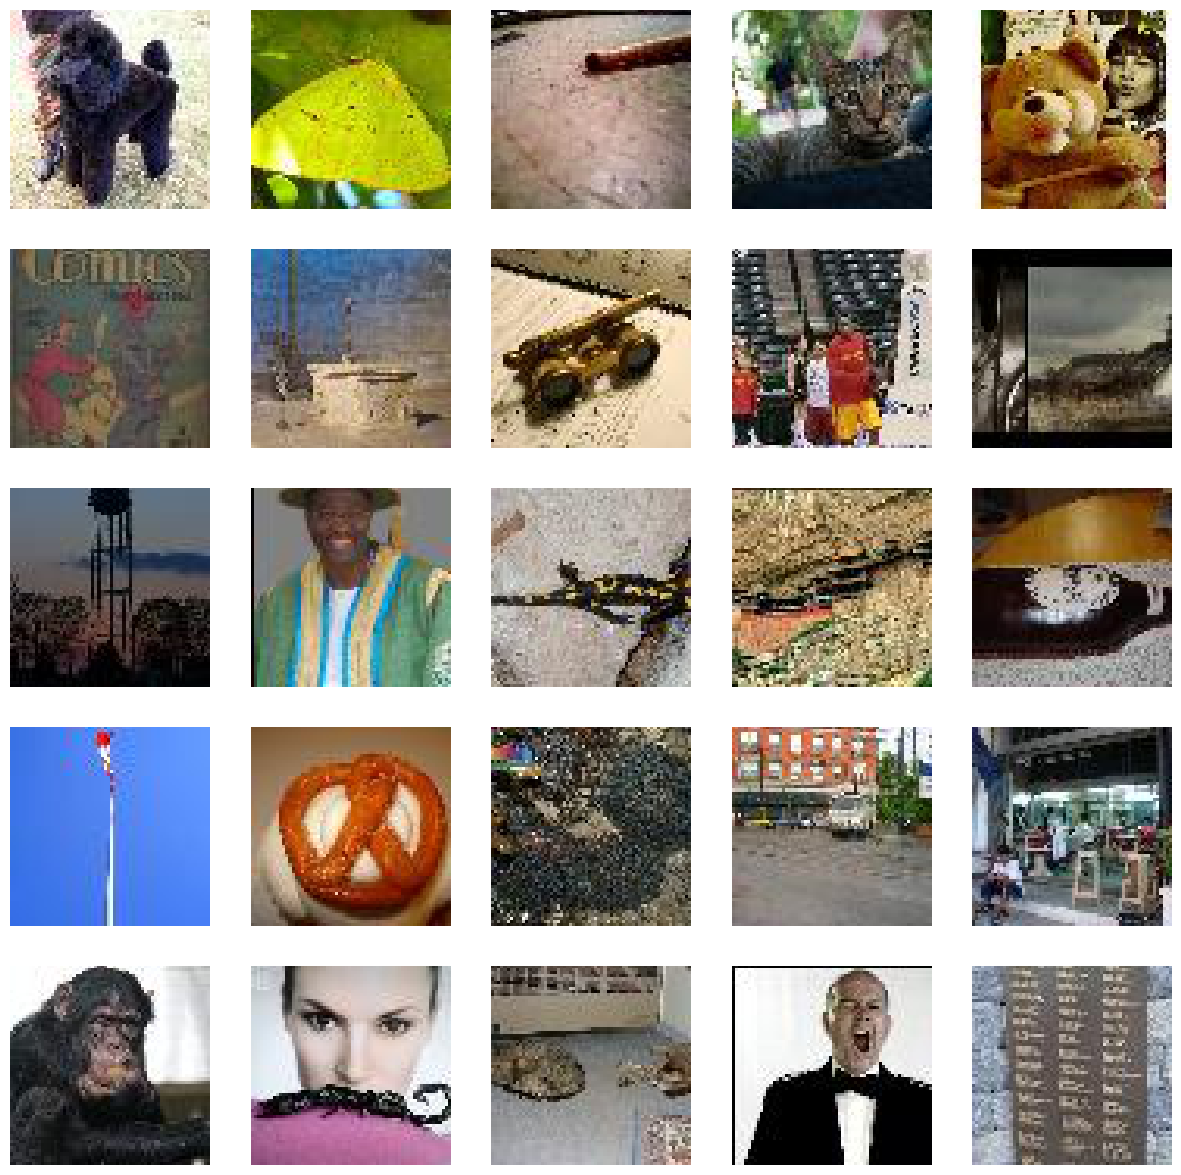

In [43]:
show_images(xb[:25]+0.0)

In [13]:
yb

tensor([178, 101, 185,  29, 147,  71,  59, 121, 123,  33, 107,  79, 152, 140,
         45, 161,  23,  19, 188, 194, 110, 143,  77,  87, 186,  78, 172,  13,
         18,  50,  10, 177])

In [14]:
from huggingface_hub import hf_hub_download
fp_json_pos2idx = hf_hub_download(repo_id=name, filename="dataset_infos.json", repo_type="dataset")
fp_idx2human = hf_hub_download(repo_id=name, filename="classes.py", repo_type="dataset")

In [15]:
import json 
   
f = open(fp_json_pos2idx,) 
data_pos2idx = json.load(f) 
f.close() 

In [16]:
# Repo provided a variable called 'i2d'
exec(open(fp_idx2human).read()) 
# Let's rename this variable to something suitable for this notebook
idx2human = i2d

In [17]:
pos2idx = data_pos2idx['Maysee--tiny-imagenet']['features']['label']['names']

In [18]:
pos2idx[0:3]

['n01443537', 'n01629819', 'n01641577']

In [19]:
list(idx2human.items())[:3]

[('n00001740', 'entity'),
 ('n00001930', 'physical entity'),
 ('n00002137', 'abstraction, abstract entity')]

In [20]:
pos2human = [idx2human[v] for k,v in enumerate(pos2idx)]

In [21]:
pos2human[0:3]

['goldfish, Carassius auratus',
 'European fire salamander, Salamandra salamandra',
 'bullfrog, Rana catesbeiana']

<Axes: >

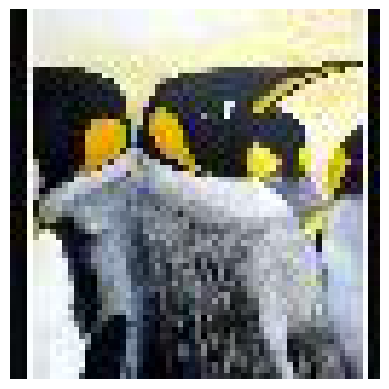

In [22]:
show_image(xb[17])

In [23]:
pos2idx[yb[17]]

'n02056570'

In [24]:
idx2human[pos2idx[yb[17]]]

'king penguin, Aptenodytes patagonica'

In [25]:
pos2human[yb[17]]

'king penguin, Aptenodytes patagonica'

In [26]:
len(pos2human)

200

In [30]:
captions = ["A photo of " + txt for txt in pos2human]

In [31]:
captions

['A photo of goldfish, Carassius auratus',
 'A photo of European fire salamander, Salamandra salamandra',
 'A photo of bullfrog, Rana catesbeiana',
 'A photo of tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 'A photo of American alligator, Alligator mississipiensis',
 'A photo of boa constrictor, Constrictor constrictor',
 'A photo of trilobite',
 'A photo of scorpion',
 'A photo of black widow, Latrodectus mactans',
 'A photo of tarantula',
 'A photo of centipede',
 'A photo of koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus',
 'A photo of jellyfish',
 'A photo of brain coral',
 'A photo of snail',
 'A photo of sea slug, nudibranch',
 'A photo of American lobster, Northern lobster, Maine lobster, Homarus americanus',
 'A photo of spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish',
 'A photo of black stork, Ciconia nigra',
 'A photo of king penguin, Aptenodytes patagonica',
 'A photo of albatross, mollymawk',
 'A photo of

### Step 1: Installation
First, ensure you have the required libraries installed:
```bash
pip install transformers
pip install torch
pip install torchvision
pip install Pillow  # For image processing
```

### Step 2: Load the CLIP Model and Preprocessing Tools
Load the CLIP model and preprocess your image and text data using the Hugging Face library.
```python
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Load the CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
```

### Step 3: Prepare the Image and Text Data
Preprocess the image and tokenize the text descriptions.
```python
# Load and preprocess the image
image_path = "path/to/your/image.jpg"
image = Image.open(image_path)

# Define the text descriptions
texts = ["a description", "another description", "yet another description"]

# Preprocess the image and texts
inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)
image_input = inputs["pixel_values"].to(device)
text_inputs = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)
```

### Step 4: Compute Features
Generate image and text embeddings using the CLIP model.
```python
with torch.no_grad():
    # Compute the image and text embeddings
    image_features = model.get_image_features(image_input)
    text_features = model.get_text_features(input_ids=text_inputs, attention_mask=attention_mask)

# Normalize the features
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
```

### Step 5: Compute Similarity and Get Results
Calculate the similarity scores between the image and each text description, and identify the best match.
```python
# Compute similarity scores
similarity_scores = image_features @ text_features.T

# Get the index of the best matching text description
best_match_index = similarity_scores.argmax().item()

# Output the best matching text description
print(f"Best match: {texts[best_match_index]} (score: {similarity_scores[0, best_match_index]:.4f})")
```